# Exploratory Data Analysis and Initial Modeling
## Stephen Kuc and Abanther Negusu
### Team 2
### ADS509

In [98]:
# importing necessary packages

import os
import re
import emoji
import pandas as pd
import numpy as np
import json
import ijson

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from string import punctuation
from wordcloud import WordCloud 

sw = stopwords.words("english")

import nltk
from nltk.tokenize import word_tokenize

# for modeling, topic modeling

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation


We will be working with vape tweets. They were imported from a .json file in a separate notebook, and converted to CSV so it could load onto our local PC.

In [2]:
# importing vape tweets

tweets = pd.read_csv("all_vape_tweets.csv", index_col = 0)

tweets.head()

C:\Users\steph\AppData\Local\Temp/ipykernel_28104/530996478.py:3: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("all_vape_tweets.csv", index_col = 0)


,create_date,key_words,match_words,retweet_count,reply_count,like_count,text,tweet_id,author_id,pull_date,coordinates_type,coordinates_type_1
0,2020-07-04,['#juul'],[],0,0,0,The latest E-Cigarette Reviews &amp; Best Deal...,1279315472194961408,581725058,2021-12-2,NaN,NaN
1,2020-07-15,['#juul'],[],0,0,0,RT @socialmediaabdo: https://t.co/jUIiE8WvQp\n...,1283357273646039040,1275512571869589504,2021-12-2,NaN,NaN
2,2020-09-17,['#juul'],[],0,0,0,https://t.co/oCJlhrecwG\n#vape\nvape\n#mrfog\n...,1306444871717335040,1284152603845316608,2021-12-2,NaN,NaN
3,2020-10-03,['#juul'],[],0,0,0,@SarahCAndersen @Nar2c2 Wer da stoners\nDm for...,1312403915426664448,1310328183737245696,2021-12-2,NaN,NaN
4,2021-08-13,['#juul'],[],0,0,0,Good morning! \nLighting up the Oneie with som...,1426126512244379648,1205233722020155392,2021-12-2,NaN,NaN


In [3]:
# let's only use relevant columns for this 

tweets_df = tweets[['text', 'retweet_count','reply_count', 'like_count']]

tweets_df.head()

,text,retweet_count,reply_count,like_count
0,The latest E-Cigarette Reviews &amp; Best Deal...,0,0,0
1,RT @socialmediaabdo: https://t.co/jUIiE8WvQp\n...,0,0,0
2,https://t.co/oCJlhrecwG\n#vape\nvape\n#mrfog\n...,0,0,0
3,@SarahCAndersen @Nar2c2 Wer da stoners\nDm for...,0,0,0
4,Good morning! \nLighting up the Oneie with som...,0,0,0


In [4]:
tweets_df.shape

(3878009, 4)

Early on, we are having trouble with MemoryError's on a lot of code; as there are over 3.8 million tweets. To limit this, and still meet the project requirements of a few hundred thousand tweets, we then tried with 750k tweets. Still, errors were run into, so we then cut it to 300k, still errors; and finally, to 250k where no MemoryErrors were an issue

In [5]:
# setting random_state seed so results are re-creatable

tweets_df = tweets_df.sample(250000, random_state = 11)

# Tokenization and data prep


## Functions

In [100]:
# Functions for tokenizing
# removing stopwords
# finding emojis
# useful regex patterns for hashtags and whitespace

# Two useful regex
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")
collapse_whitespace = re.compile(r'\s+')

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
punctuation = punctuation - {"#"} # getting rid of hashtags

# creating a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

                             
# FUNCTIONS

# tokenize
def tokenize(tweet) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(tweet)])


# remove stopwords
def remove_stop(tokens) :
    return [t for t in tokens if t.lower() not in sw]

# checking if it contains emojis 

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# removing punctuation
# setting equal to punctuation set earlier 

def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# extracting emojis

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

# prepare function to add to pipeline

def prepare(text, pipeline) :
    tokens = str(text)
    
    for transform in pipeline:
        tokens = transform(tokens)
        
    return(tokens)


# For displaying topics of topic models

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

### Initial Cleaning

In [7]:
# setting pipeline

pipe_clean = [str.lower, remove_punctuation, tokenize, remove_stop]

tweets_df['tokens'] = tweets_df['text'].apply(prepare, pipeline = pipe_clean)


In [8]:
# Extracting emoji data

tweets_df['has_emoji'] = tweets_df['text'].apply(contains_emoji)

In [9]:
tweets_df['emojis'] = tweets_df['text'].apply(extract_emojis)

In [10]:
tweets_df.head()

,text,retweet_count,reply_count,like_count,tokens,has_emoji,emojis
3313139,"@Marrkwis By juul themselves, like it was an o...",0,1,0,"[marrkwis, juul, like, official, one]",False,
3573857,RT @Isaac_DeTemple: Can I hit your juul cmon d...,45598,0,0,"[rt, isaacdetemple, hit, juul, cmon, dood, jut...",False,
3480492,RT @EnoughNic: Juul has created nicotine addic...,73473,0,0,"[rt, enoughnic, juul, created, nicotine, addic...",False,
307455,can someone get me some water i just ripped my...,0,0,9,"[someone, get, water, ripped, juul, way, hard]",False,
3070023,@PfaffMd @EdwardHubert4 @NYSMom4Kiddos @JUULva...,0,0,1,"[pfaffmd, edwardhubert4, nysmom4kiddos, juulva...",False,


### Descriptive Statistics

We will be writing a function to pull out relevant descriptive statistics from our text. We will also explore the likes, retweets, and reply data.

In [11]:
# writing descriptive_stats fucntion below

def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        This function will do the following:
        Given a list of tokens, it will return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    

    # finding total number of tokens by the length of tokens list
    num_tokens = len(tokens)
    
    # creating a set of tokens to find unique, and then length of that
    num_unique_tokens = len(set(tokens))
    
    # dividing unique over total to find diversity
    lexical_diversity = num_unique_tokens / num_tokens
    
    
    # creating a quick for-loop to cound all characters in document
    num_characters_list = []
    for word in tokens:
        num_characters_list.append(len(word))
        
    num_characters = sum(num_characters_list)
    
    # utilizing Counter to count the characters and then finding the top 10
    
    common_count = Counter(tokens)
    
    most_common_ten = common_count.most_common(10)
        
    
    if verbose == True:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"These are the ten most common tokens and their count:\n {most_common_ten}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, most_common_ten])
    

In [12]:
tweet_tokens = [i for sublist in tweets_df['tokens'] for i in sublist]

print(descriptive_stats(tweet_tokens))

There are 3035702 tokens in the data.
There are 167219 unique tokens in the data.
There are 17302100 characters in the data.
The lexical diversity is 0.055 in the data.
These are the ten most common tokens and their count:
 [('juul', 235532), ('rt', 138447), ('pods', 26659), ('hit', 25201), ('like', 23957), ('nicotine', 19298), ('smoking', 17549), ('pod', 16515), ('u', 13964), ('it’s', 12249)]
[3035702, 167219, 0.055084128811062484, 17302100, [('juul', 235532), ('rt', 138447), ('pods', 26659), ('hit', 25201), ('like', 23957), ('nicotine', 19298), ('smoking', 17549), ('pod', 16515), ('u', 13964), ('it’s', 12249)]]


Understanding these are tweets, it seems to be reasonable that there would be a low lexical diversity of .055. There were less unique tokens than total tweets in the dataset, as well. 

The biggest takeaways lie within the top 10 most common tokens. As we're interested in vape data, and many of the keyword searches included words here like 'juul', it makes sense to see those words here. Juul seems to be far away the most talked about brand, though, with nearly a mention per tweet (235k / 250k). The word 'rt' being high up makes sense, as on twitter, an 'rt' is when a user retweets something. It's automatically printed in the following tweet. This is something that should be taken out.

Other words mostly have to do with vaping and the act of it, as well. Like 'hit', 'nicotine', and 'smoking'. It appears 'pod' and 'pods' were each counted once, though, both have to do with vaping. Overall, though, these seem to be mostly talking about vaping, with some other words that seem to be common on twitter.

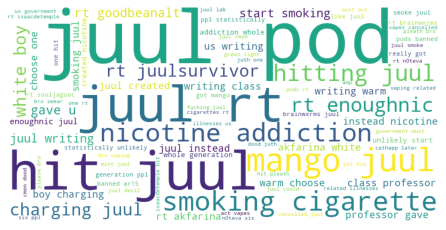

In [122]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = sw, 
            min_font_size = 10).generate(' '.join(tweet_tokens))

plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

This seems to lineup a lot with what was seen in the top 10. There is some references to cigaretters; a lot to 'hitting' the juul, and many rt's from certain twitter handles. These seem to include enoughnic, juulsurvivor, akfarina, and goodbeanalt. There are also somethat may refer to students or kids using them like "class" "professor", "writing", "boy". 

Overall, the most used words seem to capture much about vape brands, the act of vaping (or smoking), the warnings against vaping (like "addiction"), or being in class/school.

There still remains some issues, so let's try to lemmatize the data.

### Further Linguistic Processing

In [14]:
# lemmetization
# more cleanup

def process_data(data):
    documents = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(data)):  
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', str(data[sen]))    
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)    
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)    
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)    
        # Converting to Lowercase
        document = document.lower()    
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)    
        documents.append(document)
    return documents

In [15]:
text = tweets_df['text']

text = list(text)

lemmetized_tweets = process_data(text)

Before applying pipeline, let's view lemmetized tweets and see if it makes sense and if any other areas to clean

Some areas still don't make sense; and we have links. need to get rid of links, as well as "&gt" or "&amp". Many of these are marked starting with &, so perhaps, a regex function can help!

In [123]:
# getting rid of HTML special entities that start with "&"

lemmetized_tweets_clean = [re.sub(r'(&\w*)', '', s) for s in lemmetized_tweets]

# getting rid of links

lemmetized_tweets_clean = [re.sub(r'(https?:\/\/.*[\r\n]*)', '', s) for s in lemmetized_tweets_clean]

# getting rid of single characters
lemmetized_tweets_clean  = [re.sub(r'\s+[a-zA-Z]\s+', ' ', s) for s in lemmetized_tweets_clean]

# getting rid of 'rts' and other observations
lemmetized_tweets_clean  = [re.sub(r'(rt)', '', s) for s in lemmetized_tweets_clean]

lemmetized_tweets_clean[1:5]

[' @isaac_detemple: can hit your juul cmon dood juth one hit pleath bro swear i’ll cathapp you later ',
 ' @enoughnic: juul ha created nicotine addiction in whole generation of ppl who were statistically unlikely to sta smoking cigarettes…',
 'can someone get me some water just ripped my juul way too hard',
 '@pfaffmd @edwardhube4 @nysmom4kiddos @juulvapor @taragonmd we can address youth usage, but prevalence of smoking isn’t statistically backed. secondly, teen will be teens. want to reduce youth use? get it out of convenience stores. cap the nicotine levels. and stop showing 2015 ad when the company doesn’t even adveise at all anymore']

In [124]:
# now applying pipe_clean to this

tweets_df['lemmetized_tweets'] = lemmetized_tweets_clean
tweets_df['lemmetized_tokens'] = tweets_df['lemmetized_tweets'].apply(prepare, pipeline = pipe_clean)

### Descriptive stats, revisited, and more EDA

In [125]:
tweet_tokens_lem = [i for sublist in tweets_df['lemmetized_tokens']  for i in sublist]

tweet_tokens_lem = [i for i in tweet_tokens_lem if i] # getting rid of blank tokens

print(descriptive_stats(tweet_tokens_lem))


There are 2799762 tokens in the data.
There are 123787 unique tokens in the data.
There are 15385100 characters in the data.
The lexical diversity is 0.044 in the data.
These are the ten most common tokens and their count:
 [('juul', 234714), ('pod', 39887), ('wa', 27531), ('hit', 26461), ('like', 24102), ('nicotine', 19134), ('smoking', 17511), ('it’s', 12238), ('one', 12205), ('i’m', 11679)]
[2799762, 123787, 0.04421340099622754, 15385100, [('juul', 234714), ('pod', 39887), ('wa', 27531), ('hit', 26461), ('like', 24102), ('nicotine', 19134), ('smoking', 17511), ('it’s', 12238), ('one', 12205), ('i’m', 11679)]]


After some more processing, 'juul' and 'pod' ended up being the top 2 words. The other verbs around the act of vaping are still prevelant, as well as nicotine, and others that can possibly describe the person tweeting, like 'i'm' and 'like'

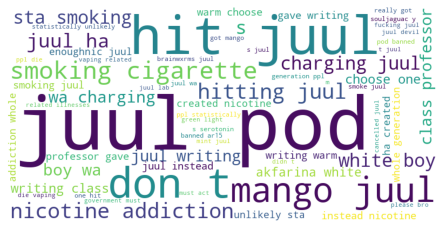

In [127]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 400, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(' '.join(tweet_tokens_lem))

plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

Many of the same words appear here as they did before, except there is less noise, like the 'rts'. Other verbs come into play as well, like "charging". It seems some of the school related words are more prevalant as well. 

In [80]:
# let's look at tweet lengths in words
# and in characters

tweet_words = []

for i in tweets_df['text']:
    tokens = tokenize(i)
    tweet_words.append(len(tokens))

        
tweets_df['tweet_words'] = tweet_words
tweets_df['tweet_chars'] = tweets_df['text'].apply(len)

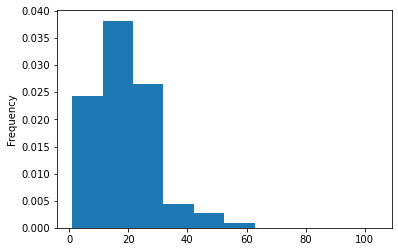

In [84]:
tweets_df['tweet_words'].plot(kind = "hist", density= True)
plt.xlabel("Amount of Words in Tweet")
plt.show()


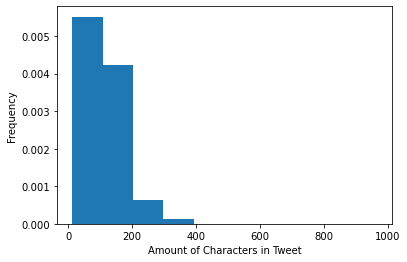

In [85]:
tweets_df['tweet_chars'].plot(kind = "hist", density= True)
plt.xlabel("Amount of Characters in Tweet")
plt.show()

As would be expected, words in a tweet typically are no higher than 40 words, with most under 20. Characters seem related to words, as of course, the more words, the more characters, and thus, they have a similar distribution. 

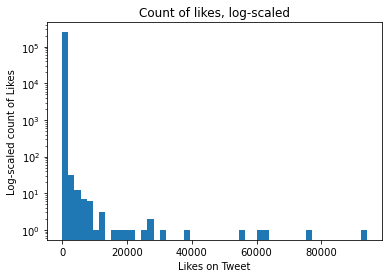

In [23]:
# plotting like counts; scaling y

plt.yscale('log')

plt.hist(tweets_df['like_count'], bins = 50)
plt.xlabel("Likes on Tweet")
plt.ylabel("Log-scaled count of Likes")
plt.title("Count of likes, log-scaled")
plt.show()


The vast majority of tweets have very little likes, but a few end up receiving tens of thousands of likes. Creating a model to classify if a tweet will have over a certain amount could be interesting.

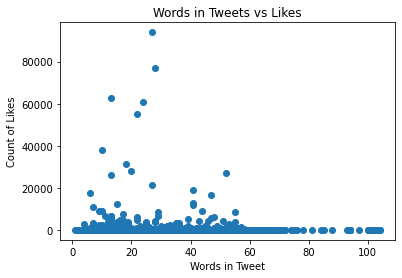

In [133]:
plt.scatter( tweets_df['tweet_words'], tweets_df['like_count'])
plt.xlabel("Words in Tweet")
plt.ylabel("Count of Likes")
plt.title("Words in Tweets vs Likes")
plt.show()


When tweets have over 50 or so words, they very rarely get a lot of likes. Also, knowing the distribution of each of these, there are a lot of data points along the 0 of the y-axis, so even though there are some with a lot of likes, it's very few relative to the rest. As characters and words have a similar distribution, so too is the below graph similar to the above one.

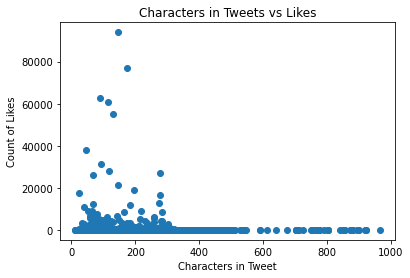

In [135]:
plt.scatter( tweets_df['tweet_chars'], tweets_df['like_count'])
plt.xlabel("Characters in Tweet")
plt.ylabel("Count of Likes")
plt.title("Characters in Tweets vs Likes")
plt.show()


An interesting concept on Twitter is around "ratio"s; that is to get "ratio"'d, which is typically when the amount of replies to a tweet are more than the likes. We're interested in exploring this a bit more.

In [136]:
# finding 'ratios' of each tweet

# writing function

def find_ratio(replies, likes):
    
    ratios = []

    for l, r in zip(likes, replies):
            if l != 0:
                rat = r/l
                ratios.append(rat)
            else:
                ratios.append(np.nan)
                
    return ratios

In [137]:
tweets_df['ratio_reply_like'] = find_ratio(tweets_df['reply_count'], tweets_df['like_count'])

In [138]:
tweets_df['ratio_reply_like']

3313139     NaN
3573857     NaN
3480492     NaN
307455     0.00
3070023    0.00
           ... 
2615693     NaN
2468427    0.25
1810807    0.00
1594031     NaN
3416115     NaN
Name: ratio_reply_like, Length: 250000, dtype: float64

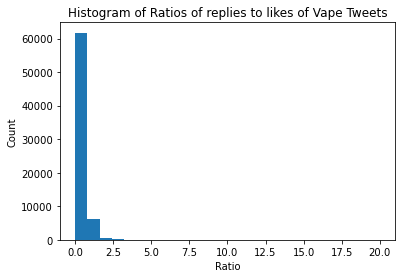

In [55]:
# let's view the distribution of this new ratio variable

plt.hist(tweets_df['ratio_reply_like'], bins = 25)
plt.title("Histogram of Ratios of replies to likes of Vape Tweets")

plt.xlabel("Ratio")

plt.ylabel("Count")

plt.show()

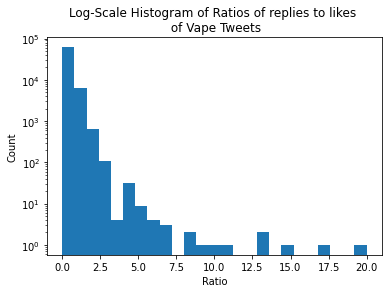

In [58]:
# viewing again, but with yscale on log

plt.yscale('log')

plt.hist(tweets_df['ratio_reply_like'], bins = 25)
plt.title("Log-Scale Histogram of Ratios of replies to likes \n of Vape Tweets")

plt.xlabel("Ratio")

plt.ylabel("Count")

plt.show()

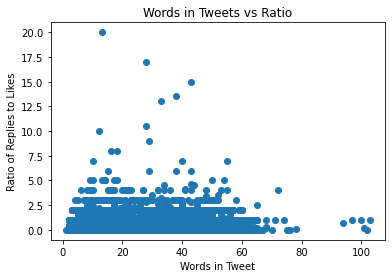

In [139]:
# let's see if there is a similar distribution as the earlier one

plt.scatter( tweets_df['tweet_words'], tweets_df['ratio_reply_like'])
plt.xlabel("Words in Tweet")
plt.ylabel("Ratio of Replies to Likes")
plt.title("Words in Tweets vs Ratio")
plt.show()


There doesn't seem to be a relationship much different than what was seen with just words vs likes. However, it does seem more people can get "ratio'd", assuming a 1:1 relationship dictates that. 

Let's create a variable for this.

In [71]:
tweets_df["high_ratio"] = np.where(tweets_df['ratio_reply_like'] >= 1, 1, 0)

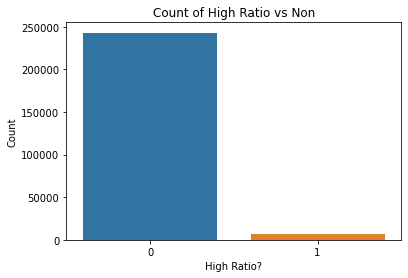

In [116]:
sns.countplot(x = 'high_ratio', data = tweets_df).set(title = "Count of High Ratio vs Non", xlabel = "High Ratio?", ylabel = "Count")

plt.show()

There is a very large descrepancy between the amount of tweets with and without a high ratio. Many more tweets are not ratio'd; then again, it is a rare occurence, especially relative to the amount of tweets out there on twitter.

Thus, if we were to try to classify this, we would need to ensure class balance.

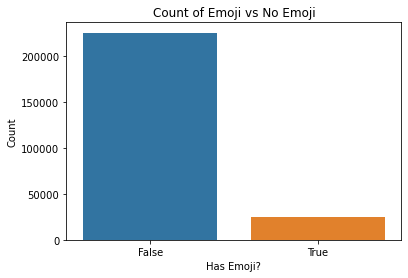

In [140]:
# let's view that emoji data extracted earlier

sns.countplot(x = 'has_emoji', data = tweets_df).set(title = "Count of Emoji vs No Emoji", xlabel = "Has Emoji?", ylabel = "Count")

plt.show()

## Sentiment Analysis

### Utilizing Vader Lexicon

The other piece of sentiment analysis with OpenAI is in a separate notebook.


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    score = analyzer.polarity_scores(text)['compound']
    if score < 0:
        return "negative"
    elif score > 0:
        return "positive"
    else:
        return "neutral"

In [27]:
tweets_df['lower_text'] = tweets_df['text'].str.lower()

tweets_df['vader'] = tweets_df['lower_text'].apply(lambda x: vader_score(x))

In [28]:
tweets_df['vader_lem'] = tweets_df['lemmetized_tweets'].apply(lambda x: vader_score(x))

<AxesSubplot:xlabel='vader'>

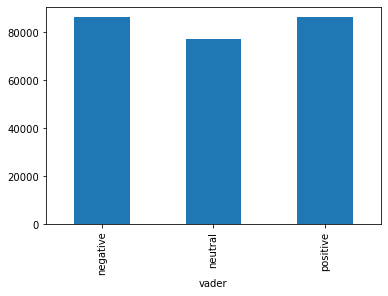

In [29]:
tweets_df.groupby("vader")['text'].count().plot(kind='bar')

<AxesSubplot:xlabel='vader_lem'>

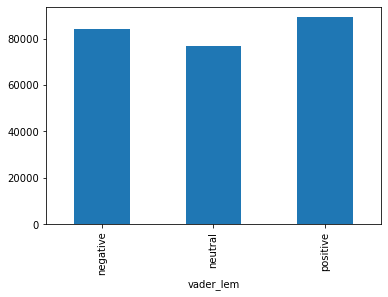

In [30]:
tweets_df.groupby("vader_lem")['text'].count().plot(kind='bar')

Using both the cleaned and further pre-processed data, it seems the sentiment was broken down similarly. There are nearly even amount of negative and positive tweets, per the VADER lexicon, with slightly more positive. There are almost a similar amount of neutral tweets, as well. 

# Topic Modeling

In [141]:
# creating tfidf vector

tfidf_text_vectorizer = TfidfVectorizer(stop_words= sw, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(tweets_df['lemmetized_tweets'])

# creating count text vector

count_text_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(tweets_df['lemmetized_tweets'])


### Non-Negative Matrix (NMF) Model

In [154]:
nmf_text_model = NMF(n_components=4, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [155]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  writing (8.79)
  akfarina_ (4.41)
  warm (4.40)
  professor (4.39)
  choose (4.38)

Topic 01
  created (4.48)
  enoughnic (4.44)
  ppl (4.37)
  generation (4.31)
  statistically (4.30)

Topic 02
  ar15s (6.46)
  souljaguac (6.44)
  banned (6.39)
  mango (6.26)
  got (6.09)

Topic 03
  serotonin (19.10)
  brainwxrms (18.29)
  instead (18.08)
  nicotine (14.15)
  nadianotpepsi (1.40)


In [156]:
# normalizing these topics and multiplying by 100 to see a percentage value of each topic
# IE finding how 'big' the topics are
# and how many documents can be assigned to each topic

W_text_matrix.sum(axis=0) / W_text_matrix.sum()*100

array([22.70464631, 27.91239314, 30.53129445, 18.8516661 ])

These topics seem to make sense. And per the normalization, they're all somewhat even. 

Topic 0 appears to be more around classes -- with writing and professor. There is what seems to be a twitter handle with 'akfarina', so it'd be interesting to learn more about that twitter account.

Topic 1 seems to be around tweets speaking against vaping and pointing to negative parts of it. Words like "created", "generation" and "statistically" seem to fit somebody speaking against the vapes and the damage it can cause. 

Topic 2 seems to be around negative things -- words like "ar15s" and "banned" could be signs of someone in trouble or trying to get in trouble. "souljaguac" also seems to be a twitter handle, and it would be interesting to see more there. Also, 'mango' does not seem to fit, although, it could be a flavor of juuls or vapes that these tweeters like. 

Topic 3 is, perhaps, having more in-depth conversations around vaping, talking about affects on serotonin or nicotine. We saw nicotine related with addiction earlier, so that could be related here as well. There seem to be another couple twitter handles in 'brainwxrms' and 'nadianotpepsi', which again would be interesting to view. 


### Truncated SVD / LSA Model

In [161]:
svd_model = TruncatedSVD(n_components = 3, random_state=42)
W_svd_matrix = svd_model.fit_transform(tfidf_text_vectors)
H_svd_matrix = svd_model.components_

In [162]:
display_topics(svd_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  writing (4.23)
  nicotine (2.23)
  wa (2.17)
  akfarina_ (2.12)
  warm (2.12)

Topic 01
  nicotine (11.65)
  serotonin (7.62)
  created (7.52)
  enoughnic (7.43)
  brainwxrms (7.32)

Topic 02
  ar15s (7.85)
  souljaguac (7.83)
  banned (7.77)
  mango (7.59)
  got (7.39)


In [163]:
W_svd_matrix.sum(axis=0) / W_svd_matrix.sum()*100

array([54.82452956, 16.4538674 , 28.72160304])

3 topics seemed to have the most even distribution for this, per the normalization. However, nicotine seems to be between topic 0 and 1. Aside from that, topics 0 seems to be similar to the last topic 0, although less obvious about school; topic 1 seems to be a mix of the people having in-depth conversations and speaking against vaping; and topic 2 seems to be the same as the other topic 2 of negative things.

### Latent Dirichlet Allocation (LDA) Model

In [168]:
# fitting LDA model

lda_text_model = LatentDirichletAllocation(n_components = 3, random_state = 42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors) # fitting LDA with count_text_vectors
H_lda_text_matrix = lda_text_model.components_


In [169]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  pod (1.66)
  like (1.22)
  vaping (0.81)
  vape (0.79)
  cigarette (0.77)

Topic 01
  hit (4.18)
  wa (2.60)
  bro (2.17)
  one (2.11)
  nicotine (2.06)

Topic 02
  pod (4.39)
  got (2.58)
  mango (1.96)
  really (1.87)
  ur (1.28)


In [170]:
W_lda_text_matrix.sum(axis=0) / W_lda_text_matrix.sum()*100

array([53.62238395, 25.19171773, 21.18589832])

Looking at these, these don't seem to be as well divided as the other topics. None seems to match up with the other derived topics.

Oveall, though, the main topics seem to be around people against vaping (who may also be willing to have deeper conversations about it), people in school, and possible trouble-makers. 

In [107]:
# saving cleaned data

# tweets_df.to_csv('cleaned_vape_tweets.csv')